In [ ]:
import os 
import os.path
import sys


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import ttest_ind


try:
    import ClearMap.Settings as settings
except:
    sys.path.append(f"/home/{os.getlogin()}/programs/ClearMap/ClearMap3")
    import ClearMap.Settings as settings
sys.path.append(f'/home/{os.getlogin()}/programs/stats3d')
from src.regional import plot_utils
from src.regional import graph_utils

## Specify paths

In [ ]:
ontology_df = pd.read_json(Path(settings.atlas_folder) / 'ABA_annotation_last.jsonl', lines=True)

In [ ]:
data_folder_base = Path(f'/raid_data/{os.getlogin()}/231012_e15vsV_idisco')

In [ ]:
result_df = pd.read_csv(data_folder_base / 'vasculature_stats_gd15.csv')
result_df.head()

,sample_id,region_id,n_vertices,n_degree_1,n_degree_3,radius,group
0,231012-1,1,196,2,162,2.127006,Virgin
1,231012-1,2,837,9,752,1.683489,Virgin
2,231012-1,4,78773,1334,67107,1.650835,Virgin
3,231012-1,6,12090,273,10619,1.689532,Virgin
4,231012-1,7,14315,145,12153,1.839457,Virgin


## Specify parameters

In [ ]:
PARAM = 'n_degree_1'
TEST = 'GD15'
CTL = 'Virgin'
SAMPLES = [1,2,3,4,6,8,9,11,12,13,15,16]
HEMISPHERE=[0,255]

## Filters

#### Filter by sample and hemisphere

In [ ]:
df = plot_utils.filter_by_samples(result_df, sample_list=SAMPLES)
df = plot_utils.filter_by_hemisphere(df, hemisphere=HEMISPHERE)

#### Optionnal: remove fiber tracts, ventricular system or non-leaf (ie non terminal) regions

In [ ]:
filtered_regions = []

for region in np.unique(ontology_df['id']):
    row = ontology_df[ontology_df['id'] == region]
    if not row.empty:
        direct_children = row['direct_children_structures_ids'].iloc[0]
        
        # Take the last node that exist in our annotation map
        if not direct_children:
            filtered_regions.append(region)
        else:
            if all(child not in result_df['Structure ID'].to_list() for child in direct_children):
                filtered_regions.append(region)

# Remove fiber tracts system:
for id in graph_utils.extract_children_coordinates(1009, ontology_df):
    if id in filtered_regions:
        filtered_regions.remove(id)

# Remove ventricular systems:
for id in graph_utils.extract_children_coordinates(73, ontology_df):
    if id in filtered_regions:
        filtered_regions.remove(id)

df = plot_utils.filter_by_region(result_df, region=filtered_regions)

## Volcano plot

In [ ]:
df_volcano = plot_utils.create_volcano_data(result_df, TEST, CTL, PARAM)

region significatively superior:  Periventricular hypothalamic nucleus, preoptic part  ( PVpo )
region significatively superior:  Nucleus ambiguus, ventral division  ( AMBv )
region significatively superior:  fourth ventricle  ( V4 )
region significatively superior:  Gustatory areas, layer 4  ( GU4 )
region significatively superior:  Dorsal auditory area, layer 6a  ( AUDd6a )
region significatively superior:  Nucleus prepositus  ( PRP )
region significatively superior:  Gustatory areas, layer 5  ( GU5 )
region significatively superior:  Lateral preoptic area  ( LPO )
region significatively superior:  Dorsal auditory area, layer 6b  ( AUDd6b )
region significatively superior:  Anteroventral periventricular nucleus  ( AVPV )
region significatively superior:  Perirhinal area, layer 6a  ( PERI6a )
region significatively superior:  Subparaventricular zone  ( SBPV )
region significatively superior:  Perirhinal area, layer 6b  ( PERI6b )
region significatively superior:  Perirhinal area, laye

Text(0.5, 1.0, 'n_degree_1 in GD15 vs Virgin')

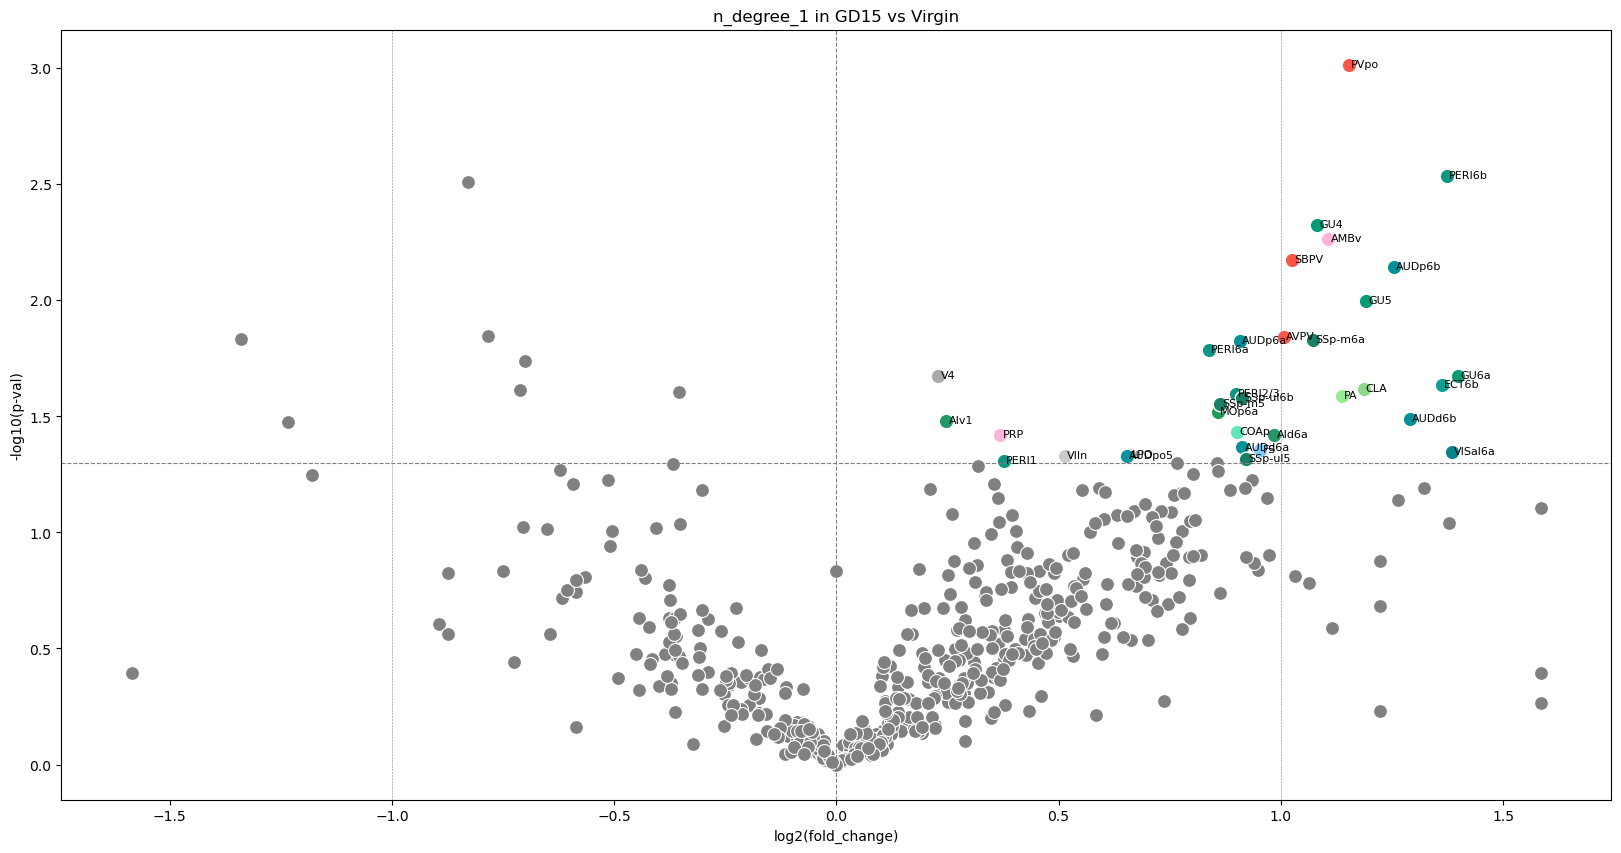

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Global plot 
sns.scatterplot(df_volcano, x="log2(fold_change)", y="-log10(p-val)", color='grey', s=100, linewidths=0.1)

# Highlight a specific region 
# plt.scatter(df_volcano[df_volcano['region_id']==272]['log2(fold_change)'], df_volcano[df_volcano['region_id']==272]["-log10(p-val)"], color='red', label='AVPV')

# Highlight significative regions 
for idx, id in enumerate(df_volcano['region_id']):
    line = df_volcano[df_volcano['region_id']==id]
    if line.at[idx,'-log10(p-val)']>1.3 and line.at[idx,'log2(fold_change)']>0 and id<11000:
        # Print the significative regions
        print(f'region significatively superior: ', ontology_df[ontology_df["id"]==id]["name"].values[0], ' (', ontology_df[ontology_df["id"]==id]["acronym"].values[0], ')')
        x = line.at[idx,'log2(fold_change)']
        y = line.at[idx,'-log10(p-val)']
        # Add color if significative region
        plt.scatter(x, y, color='#'+ontology_df[ontology_df["id"]==id]['color_hex_triplet'], edgecolor='white', s=110, linewidths=0.1)
        # Add name if significative region
        acronym = ontology_df[ontology_df["id"]==id]['acronym'].values[0]
        plt.text(x+0.005, y-0.01, ontology_df[ontology_df["id"]==id]['acronym'].values[0], fontsize=8)
        # patterns = ['SSp', 'AUD', 'MO']
        # if any(pattern in acronym for pattern in patterns):
        #     plt.text(x+0.005, y-0.01, ontology_df[ontology_df["id"]==id]['acronym'].values[0], fontsize=8)

plt.axvline(x = 0, color = 'grey', linestyle='--', linewidth = 0.8)
plt.axhline(y = 1.3, color = 'grey', linestyle='--', linewidth = 0.8)

plt.title(f'{PARAM} in {TEST} vs {CTL}', fontsize="18")
plt.xlabel('log2(fold change)', fontsize="16")
plt.ylabel('-log10(p-val)', fontsize="16")
plt.xticks(fontsize=15)  # Change x-axis tick label size
plt.yticks(fontsize=15) 

# plt.xlim(0, 1)
# plt.ylim(1.3, 3.25)
plt.savefig(data_folder_base + 'volcano_final.pdf', bbox_inches='tight', transparent=True) 